In [5]:
import shap
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.model_selection import train_test_split

def split_data(df, predValName):
    X = df.drop(predValName, axis=1)
    y = df[predValName]

    return (X,y)

def shap_xgboost(df, predValName, numsim):
    numsim = int(numsim)
    df = df.sample(n=(5*numsim), random_state=1)
    X,y = split_data(df, predValName)

    # create a train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    d_train = xgboost.DMatrix(X_train, label=y_train)
    d_test = xgboost.DMatrix(X_test, label=y_test)

    model = xgboost.train({"learning_rate": 0.01}, d_train, 100)
    
    model_bytearray = model.save_raw()[4:]
    def myfun(self=None):
        return model_bytearray

    model.save_raw = myfun
    

    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test, check_additivity=False)

    return shap_values, explainer.expected_value, X_test

if __name__ == "__main__":
    datasets = [
        "edge_covid_cases_city_daily.csv",
        "edge_covid_deaths_city_daily.csv",
        "edge_google_mobility_city_daily.csv",
        "edge_low_inc_earnings_small_business_city_daily.csv",
        "edge_womply_revenue_city_daily.csv"
    ]

    dataframes = [pd.read_csv(d).drop(['LOAN_NUMBER', 'FactorDate'], axis=1) for d in datasets]

    df_merged = reduce(lambda left,right: pd.merge(left, right, on=['TradeDate', 'City']), dataframes)
    Xy_columns = ['cases', 'new_cases', 'deaths',
       'new_deaths', 'retail_rec',
       'grocery_meds', 'parks', 'transit',
       'work', 'home', 'pay',
       'revenue_all'
       ]
    df = df_merged[Xy_columns]
    predict_val = 'revenue_all'
    numsim = 200

    shap_values, expected_value, stest = shap_xgboost(df, predict_val, numsim)

    

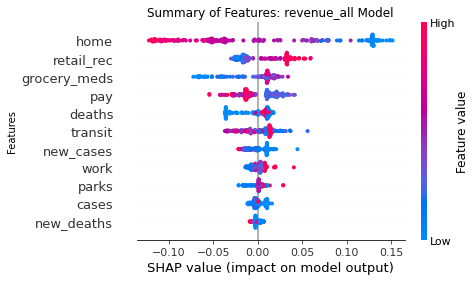

In [11]:
# Summary Plot
plt.title(label="Summary of Features: " + predict_val + " Model")
plt.ylabel(ylabel="Features")
plt.xlabel(xlabel="Model Impact")
shap.summary_plot(shap_values, stest,show=True, plot_size=None)

    
    

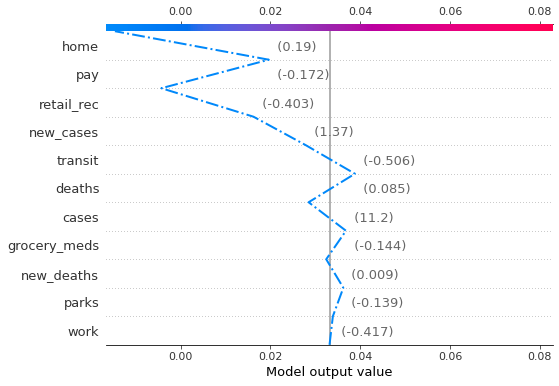

In [8]:
# Path Plot
sample_index = numsim-1
plt.xlabel(xlabel="Model Output Value")
shap.decision_plot(expected_value, shap_values[sample_index], stest, feature_names=stest.columns.tolist(), show=True, highlight=0)


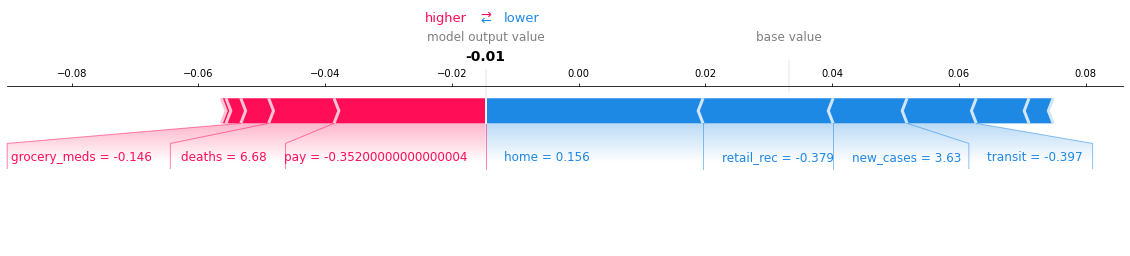

In [9]:
# Force Plot
# plt.title(label="Feature Interaction: " + predict_val + " Model")
sample_index = numsim-1
shap.force_plot(expected_value, shap_values[sample_index], stest.iloc[sample_index], feature_names=stest.columns.tolist(),matplotlib=True, show=True)
# shap.force_plot(expected_value, shap_values, stest)
